In this project, we wanted to see how features other than population influenced the total number of coronavirus infections in a county. Is population the only factor, or do the risk factors in the county/levels of mobility make a significant difference as well?

In [0]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import datetime as dt
import sklearn
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score # USE THIS, NOT MEAN_SQUARED_ERROR
from sklearn.tree import DecisionTreeRegressor
from sklearn import linear_model
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction import DictVectorizer

from sklearn.preprocessing import OneHotEncoder

In [2]:
from google.colab import files
uploaded = files.upload()

Saving time_series_covid19_deaths_US_final.csv to time_series_covid19_deaths_US_final.csv
Saving time_series_covid19_confirmed_US_final.csv to time_series_covid19_confirmed_US_final.csv
Saving county_data_abridged_final.csv to county_data_abridged_final.csv
Saving Global_Mobility_Report.csv to Global_Mobility_Report.csv


In [71]:
google_mobility_data = pd.read_csv("Global_Mobility_Report.csv")
counties = pd.read_csv("county_data_abridged_final.csv")
confirmed = pd.read_csv("time_series_covid19_confirmed_US_final.csv").fillna({"Admin2": "", 'Province_State': "", 'Country_Region': "", "iso2":"", "iso3":""})
deaths = pd.read_csv("time_series_covid19_deaths_US_final.csv").fillna({"Admin2": "", 'Province_State': "", 'Country_Region': "", "iso2":"", "iso3":""})
# These are used so that modifications to dataframes don't persist if mistakes are made
confirmed_copy = confirmed.copy()
counties_copy = counties.copy()
deaths_copy = deaths.copy()

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (3) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


The below code walks through our data cleaning. First, we merge the confirmed and counties dataframes and deal with all the resulting null values.

In [0]:
#source: rogerallen github

us_state_abbrev = {
    'Alabama': 'AL',
    'Alaska': 'AK',
    'American Samoa': 'AS',
    'Arizona': 'AZ',
    'Arkansas': 'AR',
    'California': 'CA',
    'Colorado': 'CO',
    'Connecticut': 'CT',
    'Delaware': 'DE',
    'District of Columbia': 'DC',
    'Florida': 'FL',
    'Georgia': 'GA',
    'Guam': 'GU',
    'Hawaii': 'HI',
    'Idaho': 'ID',
    'Illinois': 'IL',
    'Indiana': 'IN',
    'Iowa': 'IA',
    'Kansas': 'KS',
    'Kentucky': 'KY',
    'Louisiana': 'LA',
    'Maine': 'ME',
    'Maryland': 'MD',
    'Massachusetts': 'MA',
    'Michigan': 'MI',
    'Minnesota': 'MN',
    'Mississippi': 'MS',
    'Missouri': 'MO',
    'Montana': 'MT',
    'Nebraska': 'NE',
    'Nevada': 'NV',
    'New Hampshire': 'NH',
    'New Jersey': 'NJ',
    'New Mexico': 'NM',
    'New York': 'NY',
    'North Carolina': 'NC',
    'North Dakota': 'ND',
    'Northern Mariana Islands':'MP',
    'Ohio': 'OH',
    'Oklahoma': 'OK',
    'Oregon': 'OR',
    'Pennsylvania': 'PA',
    'Puerto Rico': 'PR',
    'Rhode Island': 'RI',
    'South Carolina': 'SC',
    'South Dakota': 'SD',
    'Tennessee': 'TN',
    'Texas': 'TX',
    'Utah': 'UT',
    'Vermont': 'VT',
    'Virgin Islands': 'VI',
    'Virginia': 'VA',
    'Washington': 'WA',
    'West Virginia': 'WV',
    'Wisconsin': 'WI',
    'Wyoming': 'WY',
    0: 'US'
}
confirmed = confirmed_copy.copy()
counties = counties_copy.copy()
# confirmed_nums is just the dates and the number of confirmed cases for each county on those dates
confirmed_nums = confirmed.drop(columns=['Country_Region', 'UID', 'iso2', 'iso3', 'code3', 'FIPS', 'Lat', "Long_", 'Province_State', 'Combined_Key','Admin2'])

# Total_Infected is the maximum number of infected people
confirmed['Total_Infected'] = confirmed_nums.max(axis=1)

# New infections is the number of infections between these two dates
confirmed["New_Infections"] = confirmed_nums["5/9/20"] - confirmed_nums["4/29/20"]

# Create a combined key of county and state to merge with
confirmed["State_Abb"] = confirmed["Province_State"].map(us_state_abbrev)
confirmed["Combined_Key"] = confirmed["Admin2"] + ", " + confirmed["State_Abb"]
counties['Combined_Key'] = counties['CountyName'] + ", " + counties["StateName"]

# drop all confirmed counts; we just care about max which we've found
list_of_dates = []
for month in range(1, 6):
  day = 1
  if month == 1:
    day = 22
  max_day = 31
  if month == 2:
    max_day = 29
  elif month == 4:
    max_day = 30
  elif month == 5:
    max_day = 12
  while day <= max_day:
    list_of_dates.append(str(month) + "/" + str(day) + "/20")
    day += 1
confirmed = confirmed.drop(columns = list_of_dates)

# If they don't match up between confirmed and counties, then we just ignore them.
confirmed_by_county = confirmed.merge(counties, how = 'inner', on = 'Combined_Key')

# drop counties with NAN population, as we can't count the infection rate for those
confirmed_by_county = confirmed_by_county[~confirmed_by_county['PopulationEstimate2018'].isnull()]
confirmed_by_county['Infection_Rate'] = confirmed_by_county['Total_Infected'] / confirmed_by_county['PopulationEstimate2018']

# HPSA is a health professional shortage area; so for areas in which it is null, we set the shortage score to 0, the underserved population to 0,
# and the served population to the estimated population.
confirmed_by_county['HPSAServedPop'] = confirmed_by_county['HPSAServedPop'].fillna(confirmed_by_county['PopulationEstimate2018'])
confirmed_by_county['HPSAUnderservedPop'] = confirmed_by_county['HPSAUnderservedPop'].fillna(confirmed_by_county['PopulationEstimate2018'] - confirmed_by_county['HPSAServedPop'])
confirmed_by_county['HPSAShortage'] = confirmed_by_county['HPSAShortage'].fillna(0)

# We won't use these, and there's way too many null values in the estimated mortality
confirmed_by_county = confirmed_by_county.drop(columns=['lat', 'lon', '#EligibleforMedicare2018', 'MedicareEnrollment,AgedTot2017', 'mortality2015-17Estimated'])

# All NaN values in State column are in Alaska, so set State to Alaska
confirmed_by_county['State'] = confirmed_by_county['State'].fillna('Alaska')

# Very few are null and all have very low populations, so probably 0 deaths
confirmed_by_county['HeartDiseaseMortality'] = confirmed_by_county['HeartDiseaseMortality'].fillna(0)
confirmed_by_county['StrokeMortality'] = confirmed_by_county['StrokeMortality'].fillna(0)

# Kalawao, Hawaii has a null dem to rep ratio, so we use the average for Hawaii from https://www.pewforum.org/religious-landscape-study/compare/party-affiliation/by/state/
confirmed_by_county.at[534, 'dem_to_rep_ratio'] = 1.82
# All of the Alaska counties' dem to rep ratio are null, so we fill in the ratio for all of Alaska from https://www.pewforum.org/religious-landscape-study/compare/party-affiliation/by/state/
confirmed_by_county['dem_to_rep_ratio'] = confirmed_by_county['dem_to_rep_ratio'].fillna(.82)

# Half of 3-YrDiabetes2015-17 is null, so let's just drop the column
confirmed_by_county = confirmed_by_county.drop(columns='3-YrDiabetes2015-17')

# Convert all dates to strings, make null values as "No Stay at Home Order"
date_categories = ['stay at home', '>50 gatherings', '>500 gatherings', 'public schools', 'restaurant dine-in', 'entertainment/gym', 'federal guidelines', 'foreign travel ban']
confirmed_by_county[date_categories] = confirmed_by_county[date_categories].fillna(0)
confirmed_by_county[date_categories] = confirmed_by_county[date_categories].astype(int).applymap(lambda x: "No Date" if x == 0 else pd.Timestamp.fromordinal(x).strftime('%Y-%m-%d'))

# Rio Arriba, New Mexico apparently had a data collection error affecting its SVI (social vulnerability index), so we'll set it to the average of all the rest (it's a percentile)
confirmed_by_county.at[1770, 'SVIPercentile'] = 50

# Set all NaN mortality to 0, since it seems like that just means 0 deaths; these are the only null values left
confirmed_by_county = confirmed_by_county.fillna(0)

Here we merge the deaths dataframe with the confirmed_by_county dataframe created above.

In [0]:
deaths = deaths_copy.copy()

# Create the combined key to merge on
deaths["State_Abb"] = deaths["Province_State"].map(us_state_abbrev)
deaths["Combined_Key"] = deaths["Admin2"] + ", " + deaths["State_Abb"]

# Total_Deaths is the max among the death counts on each day
death_nums = deaths.drop(columns=['UID', 'iso2', 'iso3', 'code3', 'FIPS', 'Admin2', 'Province_State', 'Country_Region', 'Lat', 'Long_','Combined_Key','State_Abb', 'Population'])
deaths['Total_Deaths'] = death_nums.max(axis=1)

# drop columns with the same name as confirmed
deaths = deaths.drop(columns=['UID', 'iso2', 'iso3', 'code3', 'FIPS', 'Admin2', 'Province_State', 'Country_Region', 'Lat', 'Long_'])

# don't need values from each date after finding max
deaths = deaths.drop(columns = list_of_dates)
deaths_by_county = deaths.merge(confirmed_by_county, how = 'inner', on = 'Combined_Key')

Here we prepare to merge our final dataframe, the mobility data.

In [0]:
# only counties in US
google_mobility_data[google_mobility_data["country_region_code"] == "US"]
google_mobility_data = google_mobility_data[~google_mobility_data["sub_region_2"].isna()]

# only get mobility data from the most recent date
google_mobility_data = google_mobility_data.sort_values("date").groupby("sub_region_2").tail(1)

# Create the combined key for the mobility data
google_mobility_data["sub_region_2"] = google_mobility_data["sub_region_2"].str.replace("County", "").str.rstrip()
google_mobility_data["State"] = google_mobility_data["sub_region_1"].map(us_state_abbrev)
google_mobility_data["Combined_Key"] = google_mobility_data["sub_region_2"] + ", " + google_mobility_data["State"]

Now we merge the mobility data with the deaths and confirmed cases and clean up any missing values. There were many counties with missing data, so we filled in the state average for those.

In [75]:
combined_data = deaths_by_county.merge(google_mobility_data, how = 'left', on = 'Combined_Key')
state_means = combined_data[["Province_State", "retail_and_recreation_percent_change_from_baseline", "grocery_and_pharmacy_percent_change_from_baseline", "parks_percent_change_from_baseline", "transit_stations_percent_change_from_baseline", "workplaces_percent_change_from_baseline", "residential_percent_change_from_baseline"]].groupby("Province_State").agg(np.mean)
retail_column = []
grocery_column = []
parks_column = []
transit_column = []
workplaces_column = []
residential_column = []
#fill rows with nan mobility values with state means
for index, row in combined_data.iterrows():
  if (pd.isna(row["retail_and_recreation_percent_change_from_baseline"])):
    state = row["Province_State"]
    retail_column.append(state_means.loc[state_means.index == state]["retail_and_recreation_percent_change_from_baseline"][0])
  else:
    retail_column.append(row["retail_and_recreation_percent_change_from_baseline"])
  if (pd.isna(row["grocery_and_pharmacy_percent_change_from_baseline"])):
    state = row["Province_State"]
    grocery_column.append(state_means.loc[state_means.index == state]["grocery_and_pharmacy_percent_change_from_baseline"][0])
  else:
    grocery_column.append(row["grocery_and_pharmacy_percent_change_from_baseline"])
  if (pd.isna(row["parks_percent_change_from_baseline"])):
    state = row["Province_State"]
    parks_column.append(state_means.loc[state_means.index == state]["parks_percent_change_from_baseline"][0])
  else:
    parks_column.append(row["parks_percent_change_from_baseline"])
  if (pd.isna(row["transit_stations_percent_change_from_baseline"])):
    state = row["Province_State"]
    transit_column.append(state_means.loc[state_means.index == state]["transit_stations_percent_change_from_baseline"][0])
  else:
    transit_column.append(row["transit_stations_percent_change_from_baseline"])
  if (pd.isna(row["workplaces_percent_change_from_baseline"])):
    state = row["Province_State"]
    workplaces_column.append(state_means.loc[state_means.index == state]["workplaces_percent_change_from_baseline"][0])
  else:
    workplaces_column.append(row["workplaces_percent_change_from_baseline"])
  if (pd.isna(row["residential_percent_change_from_baseline"])):
    state = row["Province_State"]
    residential_column.append(state_means.loc[state_means.index == state]["residential_percent_change_from_baseline"][0])
  else:
    residential_column.append(row["residential_percent_change_from_baseline"])
combined_data["retail_and_recreation_percent_change_from_baseline"] = retail_column
combined_data["grocery_and_pharmacy_percent_change_from_baseline"] = grocery_column
combined_data["parks_percent_change_from_baseline"] = parks_column
combined_data["transit_stations_percent_change_from_baseline"] = transit_column
combined_data["workplaces_percent_change_from_baseline"] = workplaces_column
combined_data["residential_percent_change_from_baseline"] = residential_column
combined_data["New_Infection_Rate"] = combined_data["New_Infections"]/combined_data["PopulationEstimate2018"]
combined_data["Death_Rate"] = combined_data["Total_Deaths"]/combined_data["Total_Infected"]


#fill remaining nan values with mean of column (this represents Lousiana, which we don't have any google mobility data for)
combined_data = combined_data.fillna(combined_data.mean())


#one hot encode date categories
old_cols = combined_data[['stay at home', '>50 gatherings', '>500 gatherings']]
dummies = pd.get_dummies(combined_data, columns = ['stay at home', '>50 gatherings', '>500 gatherings'])
combined_data = pd.concat([old_cols, dummies.set_index(combined_data.index)], axis=1)
combined_data

,stay at home,>50 gatherings,>500 gatherings,Combined_Key,Population,5/13/20_x,5/14/20_x,State_Abb_x,Total_Deaths,UID,iso2,iso3,code3,FIPS,Admin2,Province_State,Country_Region,Lat,Long_,5/13/20_y,5/14/20_y,Total_Infected,New_Infections,State_Abb_y,countyFIPS,STATEFP,COUNTYFP,CountyName,StateName,State_x,POP_LATITUDE,POP_LONGITUDE,CensusRegionName,CensusDivisionName,Rural-UrbanContinuumCode2013,PopulationEstimate2018,PopTotalMale2017,PopTotalFemale2017,FracMale2017,PopulationEstimate65+2017,...,>50 gatherings_2020-03-15,>50 gatherings_2020-03-16,>50 gatherings_2020-03-17,>50 gatherings_2020-03-18,>50 gatherings_2020-03-19,>50 gatherings_2020-03-20,>50 gatherings_2020-03-21,>50 gatherings_2020-03-22,>50 gatherings_2020-03-23,>50 gatherings_2020-03-24,>50 gatherings_2020-03-25,>50 gatherings_2020-03-26,>50 gatherings_2020-03-27,>50 gatherings_2020-03-28,>50 gatherings_2020-03-29,>50 gatherings_2020-03-30,>50 gatherings_2020-04-02,>50 gatherings_No Date,>500 gatherings_2020-03-11,>500 gatherings_2020-03-12,>500 gatherings_2020-03-13,>500 gatherings_2020-03-14,>500 gatherings_2020-03-15,>500 gatherings_2020-03-16,>500 gatherings_2020-03-17,>500 gatherings_2020-03-18,>500 gatherings_2020-03-19,>500 gatherings_2020-03-20,>500 gatherings_2020-03-21,>500 gatherings_2020-03-22,>500 gatherings_2020-03-23,>500 gatherings_2020-03-24,>500 gatherings_2020-03-25,>500 gatherings_2020-03-26,>500 gatherings_2020-03-27,>500 gatherings_2020-03-28,>500 gatherings_2020-03-29,>500 gatherings_2020-03-30,>500 gatherings_2020-04-02,>500 gatherings_No Date
0,2020-04-04,2020-03-20,2020-03-13,"Autauga, AL",55869,4,4,AL,4,84001001,US,USA,840,1001.0,Autauga,Alabama,US,32.539527,-86.644082,93,104,104,25,AL,01001,1.0,1.0,Autauga,AL,Alabama,32.500389,-86.494165,South,East South Central,2.0,55601.0,27007.0,28497.0,0.486578,8392.0,...,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,2020-04-04,2020-03-20,2020-03-13,"Baldwin, AL",223234,7,8,AL,8,84001003,US,USA,840,1003.0,Baldwin,Alabama,US,30.727750,-87.722071,231,243,243,42,AL,01003,1.0,3.0,Baldwin,AL,Alabama,30.548923,-87.762381,South,East South Central,3.0,218022.0,103225.0,109403.0,0.485472,42413.0,...,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,2020-04-04,2020-03-20,2020-03-13,"Barbour, AL",24686,1,1,AL,1,84001005,US,USA,840,1005.0,Barbour,Alabama,US,31.868263,-85.387129,69,74,74,21,AL,01005,1.0,5.0,Barbour,AL,Alabama,31.844036,-85.310038,South,East South Central,6.0,24881.0,13335.0,11935.0,0.527701,4757.0,...,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,2020-04-04,2020-03-20,2020-03-13,"Bibb, AL",22394,1,1,AL,1,84001007,US,USA,840,1007.0,Bibb,Alabama,US,32.996421,-87.125115,46,46,46,3,AL,01007,1.0,7.0,Bibb,AL,Alabama,33.030921,-87.127659,South,East South Central,1.0,22400.0,12138.0,10530.0,0.535469,3632.0,...,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,2020-04-04,2020-03-20,2020-03-13,"Blount, AL",57826,0,0,AL,0,84001009,US,USA,840,1009.0,Blount,Alabama,US,33.982109,-86.567906,45,45,45,8,AL,01009,1.0,9.0,Blount,AL,Alabama,33.955243,-86.591491,South,East South Central,1.0,57840.0,28607.0,29406.0,0.493114,10351.0,...,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3054,2020-03-28,2020-03-20,2020-03-20,"Sweetwater, WY",42343,0,0,WY,0,84056037,US,USA,840,56037.0,Sweetwater,Wyoming,US,41.659439,-108.882788,20,21,21,2,WY,56037,56.0,37.0,Sweetwater,WY,Wyoming,41.580266,-109.295115,West,Mountain,5.0,43051.0,22440.0,21094.0,0.515459,4952.0,...,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0

Our goal is to try to predict the total number of infections in a county. Because number of infections is clearly dependent on population, we will use a linear regression model with population as a base model to compare our model to.

Text(0.5, 1.0, 'Population vs. Total Infected')

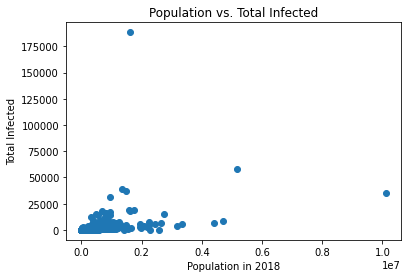

In [76]:
#graph of population vs total infected
plt.scatter(combined_data['PopulationEstimate2018'], combined_data["Total_Infected"])
plt.xlabel("Population in 2018")
plt.ylabel("Total Infected")
plt.title("Population vs. Total Infected")


There seem to be a few outliers which behave significantly differently from the remaining counties. Let's take a look at these outliers.



In [77]:
combined_data.query("Total_Infected > 100000 | PopulationEstimate2018 > .3e7")

,stay at home,>50 gatherings,>500 gatherings,Combined_Key,Population,5/13/20_x,5/14/20_x,State_Abb_x,Total_Deaths,UID,iso2,iso3,code3,FIPS,Admin2,Province_State,Country_Region,Lat,Long_,5/13/20_y,5/14/20_y,Total_Infected,New_Infections,State_Abb_y,countyFIPS,STATEFP,COUNTYFP,CountyName,StateName,State_x,POP_LATITUDE,POP_LONGITUDE,CensusRegionName,CensusDivisionName,Rural-UrbanContinuumCode2013,PopulationEstimate2018,PopTotalMale2017,PopTotalFemale2017,FracMale2017,PopulationEstimate65+2017,...,>50 gatherings_2020-03-15,>50 gatherings_2020-03-16,>50 gatherings_2020-03-17,>50 gatherings_2020-03-18,>50 gatherings_2020-03-19,>50 gatherings_2020-03-20,>50 gatherings_2020-03-21,>50 gatherings_2020-03-22,>50 gatherings_2020-03-23,>50 gatherings_2020-03-24,>50 gatherings_2020-03-25,>50 gatherings_2020-03-26,>50 gatherings_2020-03-27,>50 gatherings_2020-03-28,>50 gatherings_2020-03-29,>50 gatherings_2020-03-30,>50 gatherings_2020-04-02,>50 gatherings_No Date,>500 gatherings_2020-03-11,>500 gatherings_2020-03-12,>500 gatherings_2020-03-13,>500 gatherings_2020-03-14,>500 gatherings_2020-03-15,>500 gatherings_2020-03-16,>500 gatherings_2020-03-17,>500 gatherings_2020-03-18,>500 gatherings_2020-03-19,>500 gatherings_2020-03-20,>500 gatherings_2020-03-21,>500 gatherings_2020-03-22,>500 gatherings_2020-03-23,>500 gatherings_2020-03-24,>500 gatherings_2020-03-25,>500 gatherings_2020-03-26,>500 gatherings_2020-03-27,>500 gatherings_2020-03-28,>500 gatherings_2020-03-29,>500 gatherings_2020-03-30,>500 gatherings_2020-04-02,>500 gatherings_No Date
95,2020-03-31,2020-03-17,2020-03-17,"Maricopa, AZ",4485414,281,292,AZ,292,84004013,US,USA,840,4013.0,Maricopa,Arizona,US,33.348359,-112.491815,6341,6599,6599,2056,AZ,04013,4.0,13.0,Maricopa,AZ,Arizona,33.493403,-112.041430,West,Mountain,1.0,4410824.0,2131219.0,2175814.0,0.494823,638316.0,...,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
195,2020-03-19,2020-03-19,2020-03-19,"Los Angeles, CA",10039107,1660,1711,CA,1711,84006037,US,USA,840,6037.0,Los Angeles,California,US,34.308284,-118.228241,34538,35392,35392,8756,CA,06037,6.0,37.0,Los Angeles,CA,California,34.065193,-118.244222,West,Pacific,1.0,10105518.0,5009834.0,5153673.0,0.492924,1343960.0,...,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
206,2020-03-19,2020-03-19,2020-03-19,"Orange, CA",3175692,80,80,CA,80,84006059,US,USA,840,6059.0,Orange,California,US,33.701475,-117.764600,3749,3968,3968,1128,CA,06059,6.0,59.0,Orange,CA,California,33.733953,-117.862880,West,Pacific,1.0,3185968.0,1574674.0,1615726.0,0.493566,456229.0,...,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
213,2020-03-19,2020-03-19,2020-03-19,"San Diego, CA",3338330,190,200,CA,200,84006073,US,USA,840,6073.0,San Diego,California,US,33.034846,-116.736533,5161,5391,5391,1230,CA,06073,6.0,73.0,San Diego,CA,California,32.883260,-117.112994,West,Pacific,1.0,3343364.0,1678982.0,1658703.0,0.503038,454826.0,...,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
596,2020-03-21,2020-03-18,2020-03-18,"Cook, IL",5150233,2589,2675,IL,2675,84017031,US,USA,840,17031.0,Cook,Illinois,US,41.841448,-87.816588,56406,58457,58457,16794,IL,17031,17.0,31.0,Cook,IL,Illinois,41.865937,-87.757714,Midwest,East North Central,1.0,5180493.0,2530605.0,2680658.0,0.485603,743329.0,...,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1813,2020-03-22,2020-03-16,2020-03-13,"New York, NY",8336817,20316,20406,NY,20406,84036061,US,USA,840,36061.0,New York,New York,US,40.767273,-73.971526,187250,188545,188545,18448,NY,36061,36.0,61.0,New York,NY,New York,40.777958,-73.966303,Northeast,Middle Atlantic,1.0,1628701.0,789070.0,875657.0,0.473994,266384.0,...,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2573,2020-03-24,2020-03-21,2020-03-14,"Harris, TX",4713325,188,193,TX,193,84048201,US,USA,840,48201.0,Harris,Texas,US,29.858649,-95.393395,

We can see that there are 7 outliers, and each of them has a significantly larger population or number of infections than the other counties. Because we are trying to build a model that predicts number of infections based on population and other features, we will not include these outliers because they are not representative of most counties in the US. Additionally, if we include them they will skew our results because our models will take their extremely large populations into account too much.

In [0]:
combined_data = combined_data[combined_data["Total_Infected"] < 100000]
combined_data = combined_data[combined_data["PopulationEstimate2018"] < .3e7]

We can also remove counties with zero infections, because they are not relevant to our goal of predicting the number of infections in a county (if coronavirus has not arrived in a county, we cannot predict what it will spread based on)

In [0]:
combined_data = combined_data[combined_data["Total_Infected"] > 0]

Now, we divide our data into a train and test set.

In [0]:
#train test split!
X_train, X_test, Y_train, Y_test = train_test_split(combined_data.drop(columns = ['Total_Infected']), combined_data[['Total_Infected']], test_size=0.33, random_state=30)
training_data = pd.concat([X_train, Y_train], axis = 1)

Now that we have our training data, we can explore it to find good features for our model.



Below we check the correlation of each of the columns of our dataframe with the total number of infected individuals. We reduce the data to that which isn't too correlated with population, since there are many categories estimating population.

In [81]:
total_infected = training_data['Total_Infected']
training_data_infected_corr = training_data.corr()
training_data_infected_corr = training_data_infected_corr[(np.square(training_data_infected_corr['Total_Infected']) > .03) & 
                                                          (np.square(training_data_infected_corr['PopulationEstimate2018']) < .25)]['Total_Infected'].sort_values()
pd.set_option('display.max_rows', training_data_infected_corr.shape[0]+1)
training_data_infected_corr

Rural-UrbanContinuumCode2013                         -0.266017
retail_and_recreation_percent_change_from_baseline   -0.246266
transit_stations_percent_change_from_baseline        -0.221709
RespMortalityRate2014                                -0.208503
workplaces_percent_change_from_baseline              -0.203467
grocery_and_pharmacy_percent_change_from_baseline    -0.202217
Smokers_Percentage                                   -0.173803
>50 gatherings_2020-03-16                             0.221783
residential_percent_change_from_baseline              0.276241
dem_to_rep_ratio                                      0.300508
Infection_Rate                                        0.335717
Name: Total_Infected, dtype: float64

Here we check the reciprocal of each of the data points.

In [82]:
non_integers = ['Combined_Key', 
 'State_Abb_x', 
 'UID', 
 'iso2', 
 'iso3', 
 'code3', 
 'FIPS', 
 'Admin2', 
 'Province_State', 
 'Country_Region', 
 'State_Abb_y', 
 'countyFIPS', 
 'STATEFP', 
 'COUNTYFP', 
 'CountyName', 
 'StateName', 
 'State_x', 
 'CensusRegionName', 
 'CensusDivisionName', 
 'country_region_code',
 'country_region',
 'sub_region_1',
 'sub_region_2',
 'date',
 'State_y']

total_infected = training_data['Total_Infected']

div_training_data = training_data.drop(columns=date_categories).drop(columns=non_integers)
# subtract the min and add .001 to avoid any divide by 0s
div_training_data = 1 / (div_training_data - div_training_data.min() + 0.001)
div_training_data['Total_Infected'] = total_infected
training_data_infected_corr = div_training_data.corr()
training_data_infected_corr = training_data_infected_corr[(np.square(training_data_infected_corr['Total_Infected']) > .03) & 
                                                          (np.square(training_data_infected_corr['PopulationEstimate2018']) < .25)]['Total_Infected'].sort_values()
pd.set_option('display.max_rows', training_data_infected_corr.shape[0]+1)
training_data_infected_corr

3-YrMortalityAge5-14Years2015-17    -0.461550
3-YrMortalityAge<1Year2015-17       -0.414882
3-YrMortalityAge15-24Years2015-17   -0.362106
New_Infection_Rate                  -0.319512
Infection_Rate                      -0.303753
3-YrMortalityAge1-4Years2015-17     -0.286699
3-YrMortalityAge25-34Years2015-17   -0.280163
3-YrMortalityAge35-44Years2015-17   -0.223350
>50 gatherings_2020-03-16           -0.221783
#HospParticipatinginNetwork2017     -0.209064
#ICU_beds                           -0.198551
5/13/20_x                           -0.190704
Total_Deaths                        -0.189818
5/14/20_x                           -0.188167
Death_Rate                          -0.186443
HPSAShortage                         0.225315
HPSAUnderservedPop                   0.225611
Rural-UrbanContinuumCode2013         0.343604
Total_Infected                       1.000000
Name: Total_Infected, dtype: float64

Here we square them.

In [83]:
total_infected = training_data['Total_Infected']

sq_training_data = np.square(training_data.drop(columns=date_categories).drop(columns=non_integers))
sq_training_data['Total_Infected'] = total_infected
training_data_infected_corr = sq_training_data.corr()
training_data_infected_corr = training_data_infected_corr[(np.square(training_data_infected_corr['Total_Infected']) > .03) & 
                                                          (np.square(training_data_infected_corr['PopulationEstimate2018']) < .25)]['Total_Infected'].sort_values()
pd.set_option('display.max_rows', training_data_infected_corr.shape[0]+1)
training_data_infected_corr

Rural-UrbanContinuumCode2013                         -0.218796
RespMortalityRate2014                                -0.174493
parks_percent_change_from_baseline                    0.174475
dem_to_rep_ratio                                      0.199942
workplaces_percent_change_from_baseline               0.202109
PopulationDensityperSqMile2010                        0.212279
>50 gatherings_2020-03-16                             0.221783
transit_stations_percent_change_from_baseline         0.248757
retail_and_recreation_percent_change_from_baseline    0.274370
residential_percent_change_from_baseline              0.305959
5/13/20_x                                             0.771354
5/14/20_x                                             0.774065
Total_Deaths                                          0.774066
5/13/20_y                                             0.833008
5/14/20_y                                             0.835546
New_Infections                                        0

Here we take the log.

In [84]:
total_infected = training_data['Total_Infected']

log_training_data = training_data.drop(columns=date_categories).drop(columns=non_integers)
# subtract the min and add .001 to avoid any divide by 0s
log_training_data = np.log(log_training_data - log_training_data.min() + 0.001)
log_training_data['Total_Infected'] = total_infected
training_data_infected_corr = log_training_data.corr()
training_data_infected_corr = training_data_infected_corr[(np.square(training_data_infected_corr['Total_Infected']) > .03) &
                                                          (np.square(training_data_infected_corr['PopulationEstimate2018']) < .25)]['Total_Infected'].sort_values()
pd.set_option('display.max_rows', training_data_infected_corr.shape[0]+1)
training_data_infected_corr

Smokers_Percentage                         -0.234336
HPSAUnderservedPop                         -0.218643
RespMortalityRate2014                      -0.213501
HPSAShortage                               -0.207350
Death_Rate                                  0.180048
#Hospitals                                  0.186602
residential_percent_change_from_baseline    0.188757
>50 gatherings_2020-03-16                   0.221783
#HospParticipatinginNetwork2017             0.255098
New_Infection_Rate                          0.281942
3-YrMortalityAge1-4Years2015-17             0.290372
Infection_Rate                              0.399437
3-YrMortalityAge5-14Years2015-17            0.463141
Total_Infected                              1.000000
Name: Total_Infected, dtype: float64

Now we have an idea of what features might be good to include in our model. Below, we explore them more deeply.

MEDIAN AGE

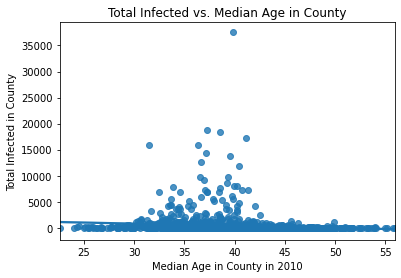

The correlation between 2010 median age in the county and total infected is  -0.12025485668598804


In [85]:
sns.regplot(data = training_data, x = 'MedianAge2010', y = 'Total_Infected')
plt.xlabel("Median Age in County in 2010")
plt.ylabel("Total Infected in County")
plt.title("Total Infected vs. Median Age in County")
plt.show()
corr = training_data["MedianAge2010"].corr(training_data["Total_Infected"])
print("The correlation between 2010 median age in the county and total infected is ", corr)

This scatterplot displays the relationship between the median age and the total number of confirmed infections in every county. As displayed in the plot, there is a sizable rise in infection counts in counties where the median age falls between 30-45 years. These areas may be cities or metropolitan areas where working age people may live and there is a more centered median age. The scatterplot helped us understand that median age could be a useful factor in predicting the infection count per county. 

DATE OF STAY AT HOME, >50 GATHERINGS ORDER, >500 GATHERINGS ORDER RURAL URBAN CONTINUUM

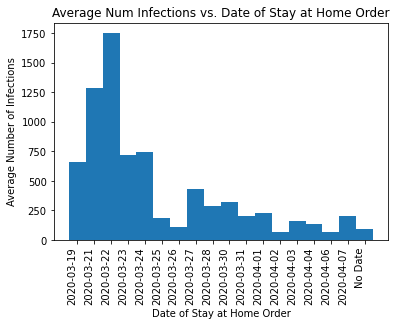

In [86]:

mobility_data = training_data[['stay at home', '>50 gatherings',
       '>500 gatherings', 'public schools', 'restaurant dine-in',
       'entertainment/gym', 'federal guidelines', 'foreign travel ban', 'Infection_Rate', 'Total_Infected']]
stay_at_home_num_inf = mobility_data.groupby('stay at home').agg({"Total_Infected": 'mean'})
plt.bar(stay_at_home_num_inf.index, stay_at_home_num_inf['Total_Infected'], width = 1)
plt.setp(plt.gca().get_xticklabels(), rotation=90, horizontalalignment='right')
plt.ylabel("Average Number of Infections")
plt.xlabel("Date of Stay at Home Order")
plt.title("Average Num Infections vs. Date of Stay at Home Order")
plt.show()

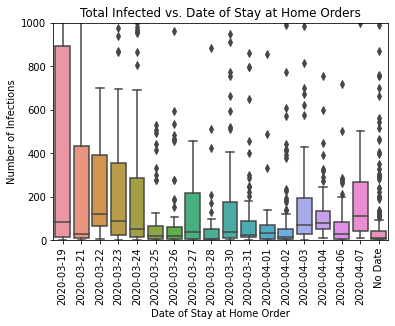

In [87]:
#same thing in boxplot form
ax = sns.boxplot(x = 'stay at home', y = 'Total_Infected', data = mobility_data, order = stay_at_home_num_inf.index)
ax.set(ylim=(0, 1000))
ax.set_xticklabels(ax.get_xticklabels(), rotation = 90)
ax.get_xticklabels()
ax.set_xlabel("Date of Stay at Home Order")
ax.set_ylabel("Number of Infections")
ax.set_title("Total Infected vs. Date of Stay at Home Orders")
plt.show()

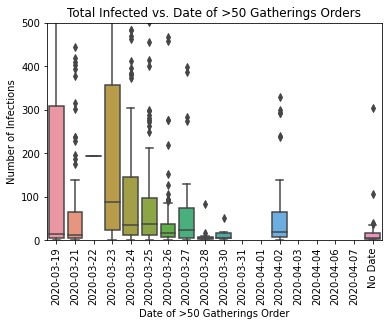

In [88]:
#>50 gatherings
ax = sns.boxplot(x = '>50 gatherings', y = 'Total_Infected', data = mobility_data, order = stay_at_home_num_inf.index)
ax.set(ylim=(0, 500))
ax.set_xticklabels(ax.get_xticklabels(), rotation = 90)
ax.get_xticklabels()
ax.set_xlabel("Date of >50 Gatherings Order")
ax.set_ylabel("Number of Infections")
ax.set_title("Total Infected vs. Date of >50 Gatherings Orders")
plt.show()

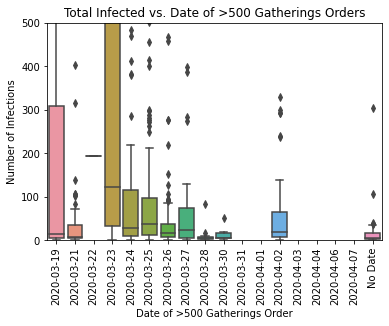

In [89]:
#>500 gatherings
ax = sns.boxplot(x = '>500 gatherings', y = 'Total_Infected', data = mobility_data, order = stay_at_home_num_inf.index)
ax.set(ylim=(0, 500))
ax.set_xticklabels(ax.get_xticklabels(), rotation = 90)
ax.get_xticklabels()
ax.set_xlabel("Date of >500 Gatherings Order")
ax.set_ylabel("Number of Infections")
ax.set_title("Total Infected vs. Date of >500 Gatherings Orders")
plt.show()

It seems like as the dates of the orders increase, the number of infections decreases. We can include these features, one-hot-encoded, in our model.

RETAIL AND RECREATION PERCENT CHANGE FROM BASELINE

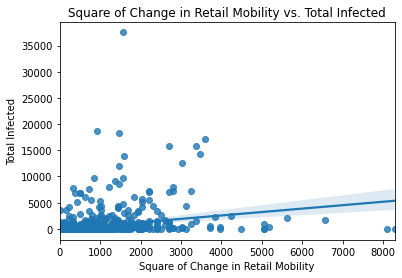

The correlation between retail mobility squared and total infected is  0.27436994079872906


In [90]:
#Based on our correlation work from earlier, I should use the square of this feature
len(training_data), training_data["retail_and_recreation_percent_change_from_baseline"].corr(training_data["Total_Infected"])
training_data["retail_mobility_transformed"] = np.square(training_data["retail_and_recreation_percent_change_from_baseline"])
sns.regplot(x = "retail_mobility_transformed", y = "Total_Infected", data = training_data)
plt.xlabel("Square of Change in Retail Mobility")
plt.ylabel("Total Infected")
plt.title("Square of Change in Retail Mobility vs. Total Infected")
plt.show()
print("The correlation between retail mobility squared and total infected is ", training_data["retail_mobility_transformed"].corr(training_data["Total_Infected"]))

The relationship between these variables still does not look very linear, but it looks like as change in mobility increases, total infected decreases. We should include both the original and transformed feature in our model, as they might do well with random forests/tree regression.

RURAL-URBAN CONTINUUM CODE

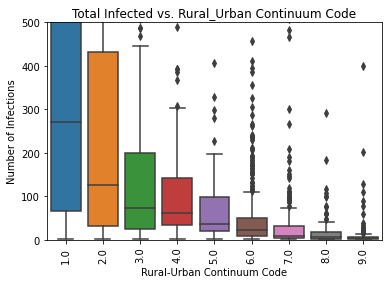

In [91]:
#Rural-Urban Continuum Code
ax = sns.boxplot(x = 'Rural-UrbanContinuumCode2013', y = 'Total_Infected', data = training_data)
ax.set(ylim=(0, 500))
ax.set_xticklabels(ax.get_xticklabels(), rotation = 90)
ax.get_xticklabels()
ax.set_xlabel("Rural-Urban Continuum Code")
ax.set_ylabel("Number of Infections")
ax.set_title("Total Infected vs. Rural_Urban Continuum Code")
plt.show()

It looks like rural-urban continuum code has a very high corrrelation with number of infections, which looks a little suspicious. Investigating the description of this variable, we see that is essentially population, so we don't include it in our model.

POPULATION DENSITY SQUARED

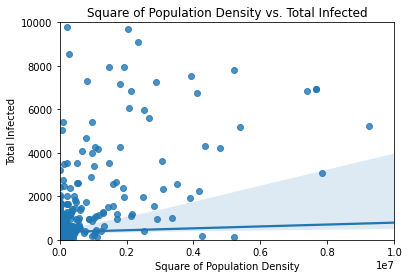

In [92]:
#Square of Population Density per Square Mile
#Based on our correlation work from earlier, I should use the square of this feature
training_data["PopulationDensityperSqMile2010_transformed"] = np.square(training_data["PopulationDensityperSqMile2010"])
ax = sns.regplot(x = "PopulationDensityperSqMile2010_transformed", y = "Total_Infected", data = training_data)
ax.set(xlim=(0, 1e7), ylim=(0,10000))
plt.xlabel("Square of Population Density")
plt.ylabel("Total Infected")
plt.title("Square of Population Density vs. Total Infected")
plt.show()

It looks like population density squared does not have a clear relationship with total infections, so we will not include it in our model.

DEMOCRATIC VS REPUBLICAN COUNTIES

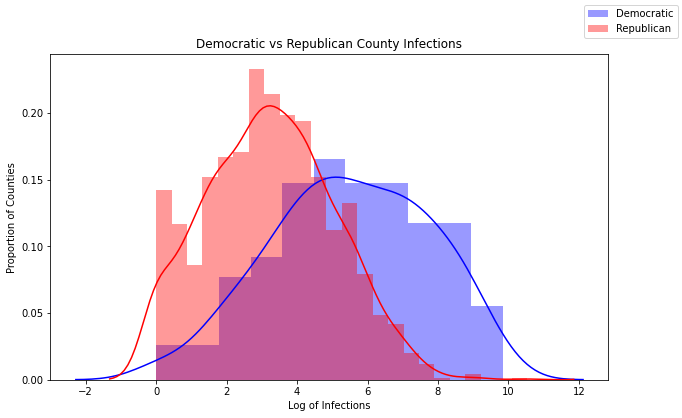

In [93]:
# Democratic counties vs Republican counties
dems = np.log(training_data[training_data['dem_to_rep_ratio'] > 1]['Total_Infected'])
reps = np.log(training_data[training_data['dem_to_rep_ratio'] < 1]['Total_Infected'])
fig = plt.figure(figsize=(10,6))
sns.distplot(dems, color="blue", label="Democratic Counties")
sns.distplot(reps, color="red", label="Republican Counties")
plt.xlabel("Log of Infections")
plt.ylabel("Proportion of Counties")
plt.title("Democratic vs Republican County Infections")
fig.legend(labels=['Democratic','Republican'])

plt.show()

It seems that Democratic counties have a higher number of infections than Republican counties, so we should include whether a county is Democratic or Republican in our model.

Now that we have explored our features, we can test them with three different models: tree regression, random forest regression, and linear ridge regression.

Here we create a helper function to compute the cross validation score of a model.

In [0]:
def get_cross_val_score(model, X, Y):
  return np.mean(np.sqrt(-cross_val_score(model, X, Y, scoring='neg_mean_squared_error')))

Here, we create a helper function to standardize our data and add the transformed features.

In [0]:
#standardize data and add transformed features
def transform_data(X):
  list_of_original_features = ['PopulationEstimate2018', 'retail_and_recreation_percent_change_from_baseline', 'residential_percent_change_from_baseline',
                    'grocery_and_pharmacy_percent_change_from_baseline', 'parks_percent_change_from_baseline', 'transit_stations_percent_change_from_baseline',
                    'workplaces_percent_change_from_baseline', 'MedianAge2010', 'SVIPercentile']
  data_subset = X[list_of_original_features]
  # Square retail mobility feature
  data_subset['retail_mobility_transformed'] = np.square(data_subset['retail_and_recreation_percent_change_from_baseline'])
  # Reciprocal of the number of smokers
  data_subset['Smokers_Percentage_Reciprocal'] = 1 / X['Smokers_Percentage']
  # Normalize the quantitative variables
  normalized = (data_subset-data_subset.mean())/data_subset.std()
  # Whether counties are more republican or democratic
  data_subset['Political Party'] = np.where(X['dem_to_rep_ratio'] < 1, 0, 1)
  #add one-hot-encoded, 'stay at home', '>50 gatherings', '>500 gatherings'
  stay_at_home_columns = X.filter(regex='stay at home').columns
  stay_at_home_data = X[stay_at_home_columns].drop(columns = ['stay at home'])
  normalized = pd.concat([normalized, stay_at_home_data], axis = 1)
  fifty_gatherings_columns = X.filter(regex = '>50 gatherings').columns
  fifty_gatherings_data = X[fifty_gatherings_columns].drop(columns = ['>50 gatherings'])
  normalized = pd.concat([normalized, fifty_gatherings_data], axis = 1)
  five_hundred_gatherings_columns = X.filter(regex = '>500 gatherings').columns
  five_hundred_gatherings_data = X[five_hundred_gatherings_columns].drop(columns = ['>500 gatherings'])
  normalized = pd.concat([normalized, five_hundred_gatherings_data], axis = 1)
  return normalized

Now we can test each model on our training data, calculating the training error and cross-validation error with the best hyperparameters.

In [97]:
#apply transform_data to our training data
normalized_combined_data = transform_data(training_data)
Y_train = training_data['Total_Infected']
normalized_combined_data

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the d

,PopulationEstimate2018,retail_and_recreation_percent_change_from_baseline,residential_percent_change_from_baseline,grocery_and_pharmacy_percent_change_from_baseline,parks_percent_change_from_baseline,transit_stations_percent_change_from_baseline,workplaces_percent_change_from_baseline,MedianAge2010,SVIPercentile,retail_mobility_transformed,Smokers_Percentage_Reciprocal,stay at home_2020-03-19,stay at home_2020-03-21,stay at home_2020-03-22,stay at home_2020-03-23,stay at home_2020-03-24,stay at home_2020-03-25,stay at home_2020-03-26,stay at home_2020-03-27,stay at home_2020-03-28,stay at home_2020-03-30,stay at home_2020-03-31,stay at home_2020-04-01,stay at home_2020-04-02,stay at home_2020-04-03,stay at home_2020-04-04,stay at home_2020-04-06,stay at home_2020-04-07,stay at home_No Date,>50 gatherings_2020-03-15,>50 gatherings_2020-03-16,>50 gatherings_2020-03-17,>50 gatherings_2020-03-18,>50 gatherings_2020-03-19,>50 gatherings_2020-03-20,>50 gatherings_2020-03-21,>50 gatherings_2020-03-22,>50 gatherings_2020-03-23,>50 gatherings_2020-03-24,>50 gatherings_2020-03-25,>50 gatherings_2020-03-26,>50 gatherings_2020-03-27,>50 gatherings_2020-03-28,>50 gatherings_2020-03-29,>50 gatherings_2020-03-30,>50 gatherings_2020-04-02,>50 gatherings_No Date,>500 gatherings_2020-03-11,>500 gatherings_2020-03-12,>500 gatherings_2020-03-13,>500 gatherings_2020-03-14,>500 gatherings_2020-03-15,>500 gatherings_2020-03-16,>500 gatherings_2020-03-17,>500 gatherings_2020-03-18,>500 gatherings_2020-03-19,>500 gatherings_2020-03-20,>500 gatherings_2020-03-21,>500 gatherings_2020-03-22,>500 gatherings_2020-03-23,>500 gatherings_2020-03-24,>500 gatherings_2020-03-25,>500 gatherings_2020-03-26,>500 gatherings_2020-03-27,>500 gatherings_2020-03-28,>500 gatherings_2020-03-29,>500 gatherings_2020-03-30,>500 gatherings_2020-04-02,>500 gatherings_No Date
683,-0.385987,0.346236,-0.589463,0.512761,0.019639,1.194212,-1.366201,0.475178,-0.482725,-0.460863,-0.727266,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
938,-0.413544,-0.039393,-0.859337,-0.897972,0.739415,0.149222,0.518721,1.075379,-0.937174,-0.179989,0.384991,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2720,-0.403530,0.240191,0.619103,-0.566406,-0.780808,-0.332847,1.224450,-1.118459,0.514596,-0.389901,0.554657,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1796,0.788222,-2.178678,1.502059,-0.965397,1.073314,-0.936958,-0.718538,0.019853,-0.307639,2.521558,0.589605,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2292,-0.140922,1.129495,-0.339830,1.461894,-0.345511,-0.179422,0.835852,-0.456168,1.502053,-0.837551,-0.506331,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
981,-0.401368,0.131529,-0.623197,0.574135,1.481849,0.539758,-1.625266,-0.187112,-0.427769,-0.312249,-0.989693,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
1236,2.288623,-2.261382,1.029780,-2.179042,1.022247,-2.212304,-1.366201,-1.180549,-0.112473,2.664900,0.585490,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
524,-0.424819,0.840030,-0.282107,0.254773,-0.539222,0.099078,0.391741,0.102640,0.984897,-0.728597,-0.082146,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
445,-0.326945,0.840030,-0.282107,0.254773,-0.539222,0.0990

In [98]:
best_max_depth = 0
best_tree_cv_score = 10000
#use cross validation to find best max depth
for i in range(10):
  tree_regression_model = DecisionTreeRegressor(max_depth= i + 1, random_state = 43)
  score = get_cross_val_score(tree_regression_model, normalized_combined_data, Y_train)
  if score < best_tree_cv_score:
    best_tree_cv_score = score
    best_max_depth = i + 1
print("using tree regression, best max depth was ", best_max_depth, " and best cross val score was ", best_tree_cv_score)
tree_regression_model = DecisionTreeRegressor(max_depth=best_max_depth, random_state = 43)
tree_regression_model.fit(normalized_combined_data, Y_train)
tree_regression_predictions = tree_regression_model.predict(normalized_combined_data)
tree_score = np.sqrt(mean_squared_error(tree_regression_predictions, Y_train))

using tree regression, best max depth was  1  and best cross val score was  1303.4251637097263


In [99]:
#trying random forests

best_max_depth = 0
best_rf_cv_score = 10000
for i in range(20):
  random_forests_many_features = RandomForestRegressor(max_depth= i + 1, random_state=0)
  score = get_cross_val_score(random_forests_many_features, normalized_combined_data, Y_train)
  if score < best_rf_cv_score:
    best_rf_cv_score = score
    best_max_depth = i + 1
print("using random forest regression, best max depth was ", best_max_depth, " and best cross val score was ", best_rf_cv_score)
random_forests_many_features = RandomForestRegressor(max_depth=best_max_depth, random_state=0)
random_forests_many_features.fit(normalized_combined_data, Y_train)
random_forest_predictions = random_forests_many_features.predict(normalized_combined_data)
random_forest_score = np.sqrt(mean_squared_error(random_forest_predictions, Y_train))

using random forest regression, best max depth was  11  and best cross val score was  1080.4589800634626


In [100]:
#trying linear ridge regression and linear regression with only population (base model)
best_alpha = 0
best_lm_cv_score = 10000
for i in range(0, 100):
  linear_model_many_features = linear_model.Ridge(alpha= i * 0.3, random_state = 12)
  score = get_cross_val_score(linear_model_many_features, normalized_combined_data, Y_train)
  if score < best_lm_cv_score:
    best_lm_cv_score = score
    best_alpha = i * .3
print("using linear ridge regression, best alpha was ", best_alpha, " and best cross val score was ", best_lm_cv_score)
linear_model_many_features = linear_model.Ridge(alpha=best_alpha, random_state=12)
linear_model_many_features.fit(normalized_combined_data, Y_train)
linear_model_many_features_predictions = linear_model_many_features.predict(normalized_combined_data)
linear_model_many_features_score = np.sqrt(mean_squared_error(linear_model_many_features_predictions, Y_train))
linear_model_base = LinearRegression()
linear_model_base.fit(normalized_combined_data[['PopulationEstimate2018']], Y_train)
linear_model_base_predictions = linear_model_base.predict(normalized_combined_data[['PopulationEstimate2018']])
linear_model_base_score = np.sqrt(mean_squared_error(linear_model_base_predictions, Y_train))
lb_cv_score = get_cross_val_score(linear_model_base, normalized_combined_data[['PopulationEstimate2018']], Y_train)
print("using linear regression with only population, cross val score was ", lb_cv_score)

using linear ridge regression, best alpha was  1.2  and best cross val score was  1171.4292627464492
using linear regression with only population, cross val score was  1258.5466191291707


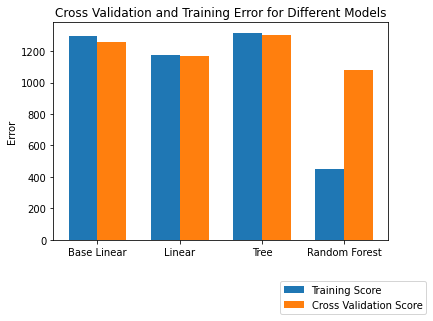

In [101]:
#plot training score and cross val score of each model
#source:matplotlib.org
labels = ['Base Linear', 'Linear', 'Tree', 'Random Forest']
training_scores = [linear_model_base_score, linear_model_many_features_score, tree_score, random_forest_score]
cv_scores = [lb_cv_score, best_lm_cv_score, best_tree_cv_score, best_rf_cv_score]

x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, training_scores, width, label='Training Score')
rects2 = ax.bar(x + width/2, cv_scores, width, label='Cross Validation Score')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Error')
ax.set_title('Cross Validation and Training Error for Different Models')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend(bbox_to_anchor=(1, 0),
           bbox_transform=plt.gcf().transFigure)

 This bar graph shows the cross validation and training error for each of our models. The random forest model has the lowest cross validation and training error, and it outperforms the base linear model, which uses only population. Now, let's compare the base linear model (uses only population) to the random forest model on our test data.

In [102]:
linear_model_base.fit(normalized_combined_data[['PopulationEstimate2018']], Y_train)
random_forests_many_features.fit(normalized_combined_data, Y_train)
normalized_X_test = transform_data(X_test)
y_linear_base_test = linear_model_base.predict(normalized_X_test[['PopulationEstimate2018']])
y_rf_many_features_test = random_forests_many_features.predict(normalized_X_test)
linear_base_test_error = np.sqrt(mean_squared_error(Y_test, y_linear_base_test))
rf_many_features_test_error = np.sqrt(mean_squared_error(Y_test, y_rf_many_features_test))
print("The base linear model, using only population, has a root mean squared error of ", linear_base_test_error)
print("The random forest model, using multiple features, has a root mean squared error of ", rf_many_features_test_error)

The base linear model, using only population, has a root mean squared error of  1690.0018627200814
The random forest model, using multiple features, has a root mean squared error of  1267.5681484535573


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the d

Throughout this process, we were trying to answer the question of whether we could predict the number of infections based on various factors about a county. Ultimately, we concluded that although our model did outperform the base linear model that used only population, it was not a significant enough difference that we could answer yes to our question. The cross validation error went down by 165, and the test error only went down by 250. This was a surprising result, because we thought that the number of infections in a county would have high correlations with features like the stay at home order date and median age. As the visualizations indicate, however, there were no extremely strong relationships between any of the features and total number of infections. 
